In [3]:
# 引入Python包，在jupyter notebook 运行后可以直接输出多个变量 注意大小写
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 指定gpu设备
import os
os.environ['CUDA_VISIBLE_DEVICES'] ="0" # gpu
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # cpu

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

In [4]:
import cv2

shape:(512, 512, 3)


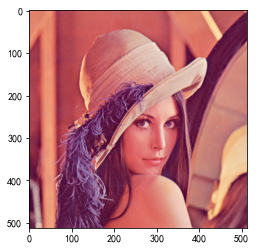

In [5]:
img = cv2.imread(r'../../dataset/lenna.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('shape:{}'.format(img.shape))
plt.imshow(img);

img.shape:(512, 512, 3), shape:(512, 512)


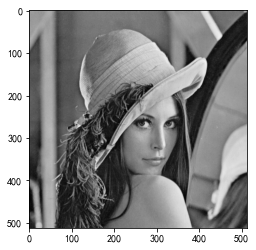

In [6]:
# 详细步骤
# 第一步， 转灰度图
def rgb2gray(img_data)->np.ndarray:
    color_R = img_data[:, :, 0].astype(np.float32)
    color_G = img_data[:, :, 1].astype(np.float32)
    color_B = img_data[:, :, 2].astype(np.float32)

    gray_data = color_R * 299/1000 + color_G * 587/1000 + color_B * 114/1000
    # np.around 向最接近的值舍入，当有两个一样接近的值时采取偶数优先策略，所谓偶数，就是二进制以0结尾的数，不是数学意义上的4舍5入
    # 而Pil模块里面的image convert使用的是数学意义上的4舍5入，所以这里进行灰度化之后和image模块转出来的图像还是会存在个别像素的差异
    gray_data = np.uint8(np.around(gray_data)) # 取整
    return gray_data

# img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(img_gray, cmap='gray')
# plt.show()

img_gray = rgb2gray(img)
img_gray
print('img.shape:{}, shape:{}'.format(img.shape, img_gray.shape))
plt.imshow(img_gray, cmap='gray');

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
[[  0   0   0 ...   0   0   0]
 [  0 162 162 ... 155 128   0]
 [  0 162 162 ... 155 128   0]
 ...
 [  0  44  44 ... 105 108   0]
 [  0  44  44 ... 105 108   0]
 [  0   0   0 ...   0   0   0]]
3
(512, 512)


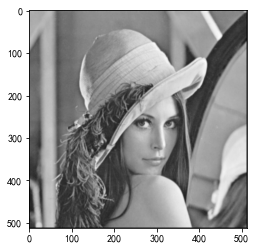

In [7]:
# 第二步，高斯滤波
# 定义滤波、卷积运算
def filter(img, kernel, padding=0, stride=1)->np.ndarray:
    output = np.zeros_like(img)
    h, w = img.shape
    if padding > 0:
        img = np.pad(img, padding)

    print(img)
    # 滑动卷积运算
    k_size = kernel.shape[0]
    print(k_size)
    h_t = int(((h - k_size + 2 * padding)/stride + 1) - k_size//2)
    w_t = int(((w - k_size + 2 * padding)/stride + 1) - k_size//2)
    for i in range(h_t):
        for j in range(w_t):
            # print(hi, wi)
            # 取出和kernel一样大的数据
            data = np.array(img[i:i+k_size, j:j+k_size])
            # print(type(data), type(kernel), data.shape, kernel.shape)
            output[i, j] = np.sum(data * kernel)
    print(output.shape)

    return output

# 定义高斯滤波器kernel
gauss_kernel = np.array([[1,2,1],[2,4,2],[1,2,1]]).astype(np.float32)
gauss_kernel /= 16

print(gauss_kernel)
gauss_img = filter(img_gray, gauss_kernel, padding=1)
plt.imshow(gauss_img, cmap='gray')

3


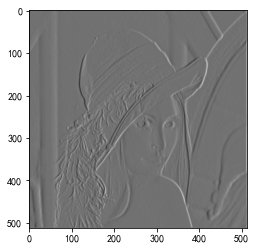

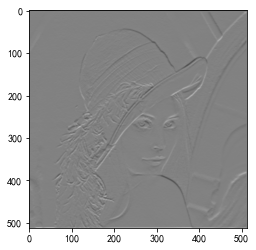

In [8]:
def sobel(img):
    g_x = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    g_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
    ag = np.zeros_like(img).astype(np.float32)
    X, Y = np.zeros_like(img).astype(np.float32), np.zeros_like(img).astype(np.float32)
    h, w = img.shape
    padding = 1
    stride = 1
    tmp = np.pad(img, padding)

    k_size = 3
    print(k_size)
    h_t = int(((h - k_size + 2 * padding)/stride + 1) - k_size//2)
    w_t = int(((w - k_size + 2 * padding)/stride + 1) - k_size//2)
    for i in range(h_t):
        for j in range(w_t):
            # print(hi, wi)
            # 取出和kernel一样大的数据
            data = np.array(tmp[i:i+k_size, j:j+k_size])
            X[i, j] = np.sum(data * g_x)
            Y[i, j] = np.sum(data * g_y)
    return X, Y

# 第三步，使用 sobel算子求边缘
fx, fy = sobel(gauss_img)
plt.imshow(fx, cmap='gray')
plt.show()

plt.imshow(fy, cmap='gray')
plt.show()

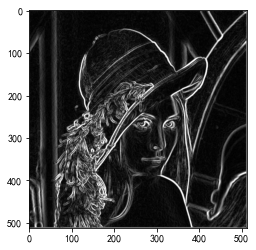

[[ 90  90  90 ...  90 135   0]
 [ 90  90  90 ...  90   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [ 90  90  90 ...  90   0   0]
 [ 90  90  90 ...  90  45   0]
 [  0   0   0 ...   0   0   0]]


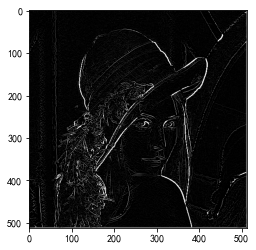

In [13]:
# get edge strength and edge angle
def get_edge_angle(fx, fy):
    # get edge strength
    edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))
    edge = np.clip(edge, 0, 255)

    # make sure the denominator is not 0
    fx = np.maximum(fx, 1e-10)
    #fx[np.abs(fx) <= 1e-5] = 1e-5

    # get edge angle
    angle = np.arctan(fy / fx)

    return edge, angle


# 将角度量化为0°、45°、90°、135°, 精度会受损
def angle_quantization(angle):
    angle = angle / np.pi * 180
    angle[angle < -22.5] = 180 + angle[angle < -22.5]
    _angle = np.zeros_like(angle, dtype=np.uint8)
    _angle[np.where(angle <= 22.5)] = 0
    _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
    _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
    _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

    return _angle

def non_maximum_suppression(angle, edge):
    H, W = angle.shape
    _edge = edge.copy()

    for y in range(1,H-1):
        for x in range(1, W-1):
                if angle[y, x] == 0:
                        dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y, x] == 45:
                        dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                        dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                        dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                # 如果不是最大值，则将这个位置像素值置为0
                if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                        _edge[y, x] = 0

    return _edge

# 非极大值抑制
# get edge strength, angle
edge, angle = get_edge_angle(fx, fy)
plt.imshow(edge, cmap='gray')
plt.show()
# angle quantization
angle = angle_quantization(angle)
print(angle)

# non maximum suppression
edge_nms = non_maximum_suppression(angle, edge)
plt.imshow(edge_nms, cmap='gray')
plt.show()

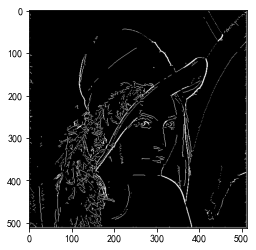

In [14]:
# 滞后阈值处理二值化图像
# > HT 的设为255，< LT 的设置0，介于它们两个中间的值，使用8邻域判断法
def hysterisis(edge, LT=30, HT=100):
    in_edge = edge.copy()
    H, W = in_edge.shape

    # Histeresis threshold
    in_edge[in_edge >= HT] = 255
    in_edge[in_edge <= LT] = 0

    _edge = np.zeros((H + 2, W + 2), dtype=np.float32)
    _edge[1 : H + 1, 1 : W + 1] = in_edge

    ## 8 - Nearest neighbor
    nn = np.array([[1., 1., 1.], [1., 0., 1.], [1., 1., 1.]], dtype=np.float32)

    for y in range(1, H+2):
            for x in range(1, W+2):
                    if _edge[y, x] < LT or _edge[y, x] > HT:
                            continue
                    if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
                            _edge[y, x] = 255
                    else:
                            _edge[y, x] = 0

    out_edge = _edge[1:H+1, 1:W+1]

    return out_edge

# hysterisis threshold
final_out = np.zeros_like(edge_nms)
final_out = hysterisis(edge_nms, 1, 128)
plt.imshow(final_out, cmap='gray')
plt.show();